In [20]:
import numpy as np
import holoviews as hv
from holoviews import opts
import xarray as xr
import hvplot.xarray

In [56]:
import xarray as xr
import xrspatial as xrs
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
import geoviews as gv
import rioxarray as rx

ModuleNotFoundError: No module named 'rioxarray'

In [57]:
#help(xrs.where())

In [55]:
data = rx.open_rasterio("https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/n19w065/USGS_1_n19w065.tif",masked =True).squeeze().astype('float64')

NameError: name 'rx' is not defined

In [51]:
data

<xarray.DataArray (y: 3612, x: 3612)>
array([[-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
        -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
       [-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
        -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
       [-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
        -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.40282306e+38, -3.40282306e+38, -3.40282306e+38]])
Coordinates:
    band     int64 1
  * y        (y) float64 19.0 19.0 19.0 19.0 19.0 ... 18.0 18.0 18.0 18.0 18.0
  * x        (x) float64 -65.0 -65.0 -65.0 -65.0 ... -64.0 -64.0 -64.0 -64.0

In [52]:
data =data.where(data>-1e38)

In [53]:
data[0,0]

<xarray.DataArray ()>
array(nan)
Coordinates:
    band     int64 1
    y        float64 19.0
    x        float64 -65.0

In [32]:
experiment=data.where(data>0,other= 0)[0,:,:]

In [36]:
experiment.astype('float64')

<xarray.DataArray (y: 3612, x: 3612)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    band     int64 1
  * y        (y) float64 19.0 19.0 19.0 19.0 19.0 ... 18.0 18.0 18.0 18.0 18.0
  * x        (x) float64 -65.0 -65.0 -65.0 -65.0 ... -64.0 -64.0 -64.0 -64.0

In [37]:
#test = xr.DataArray([[i for i in range(300)],[i for i in range(300)],[ i for i in range(300)]])

In [39]:
curve = xrs.curvature(experiment.astype('float64'))

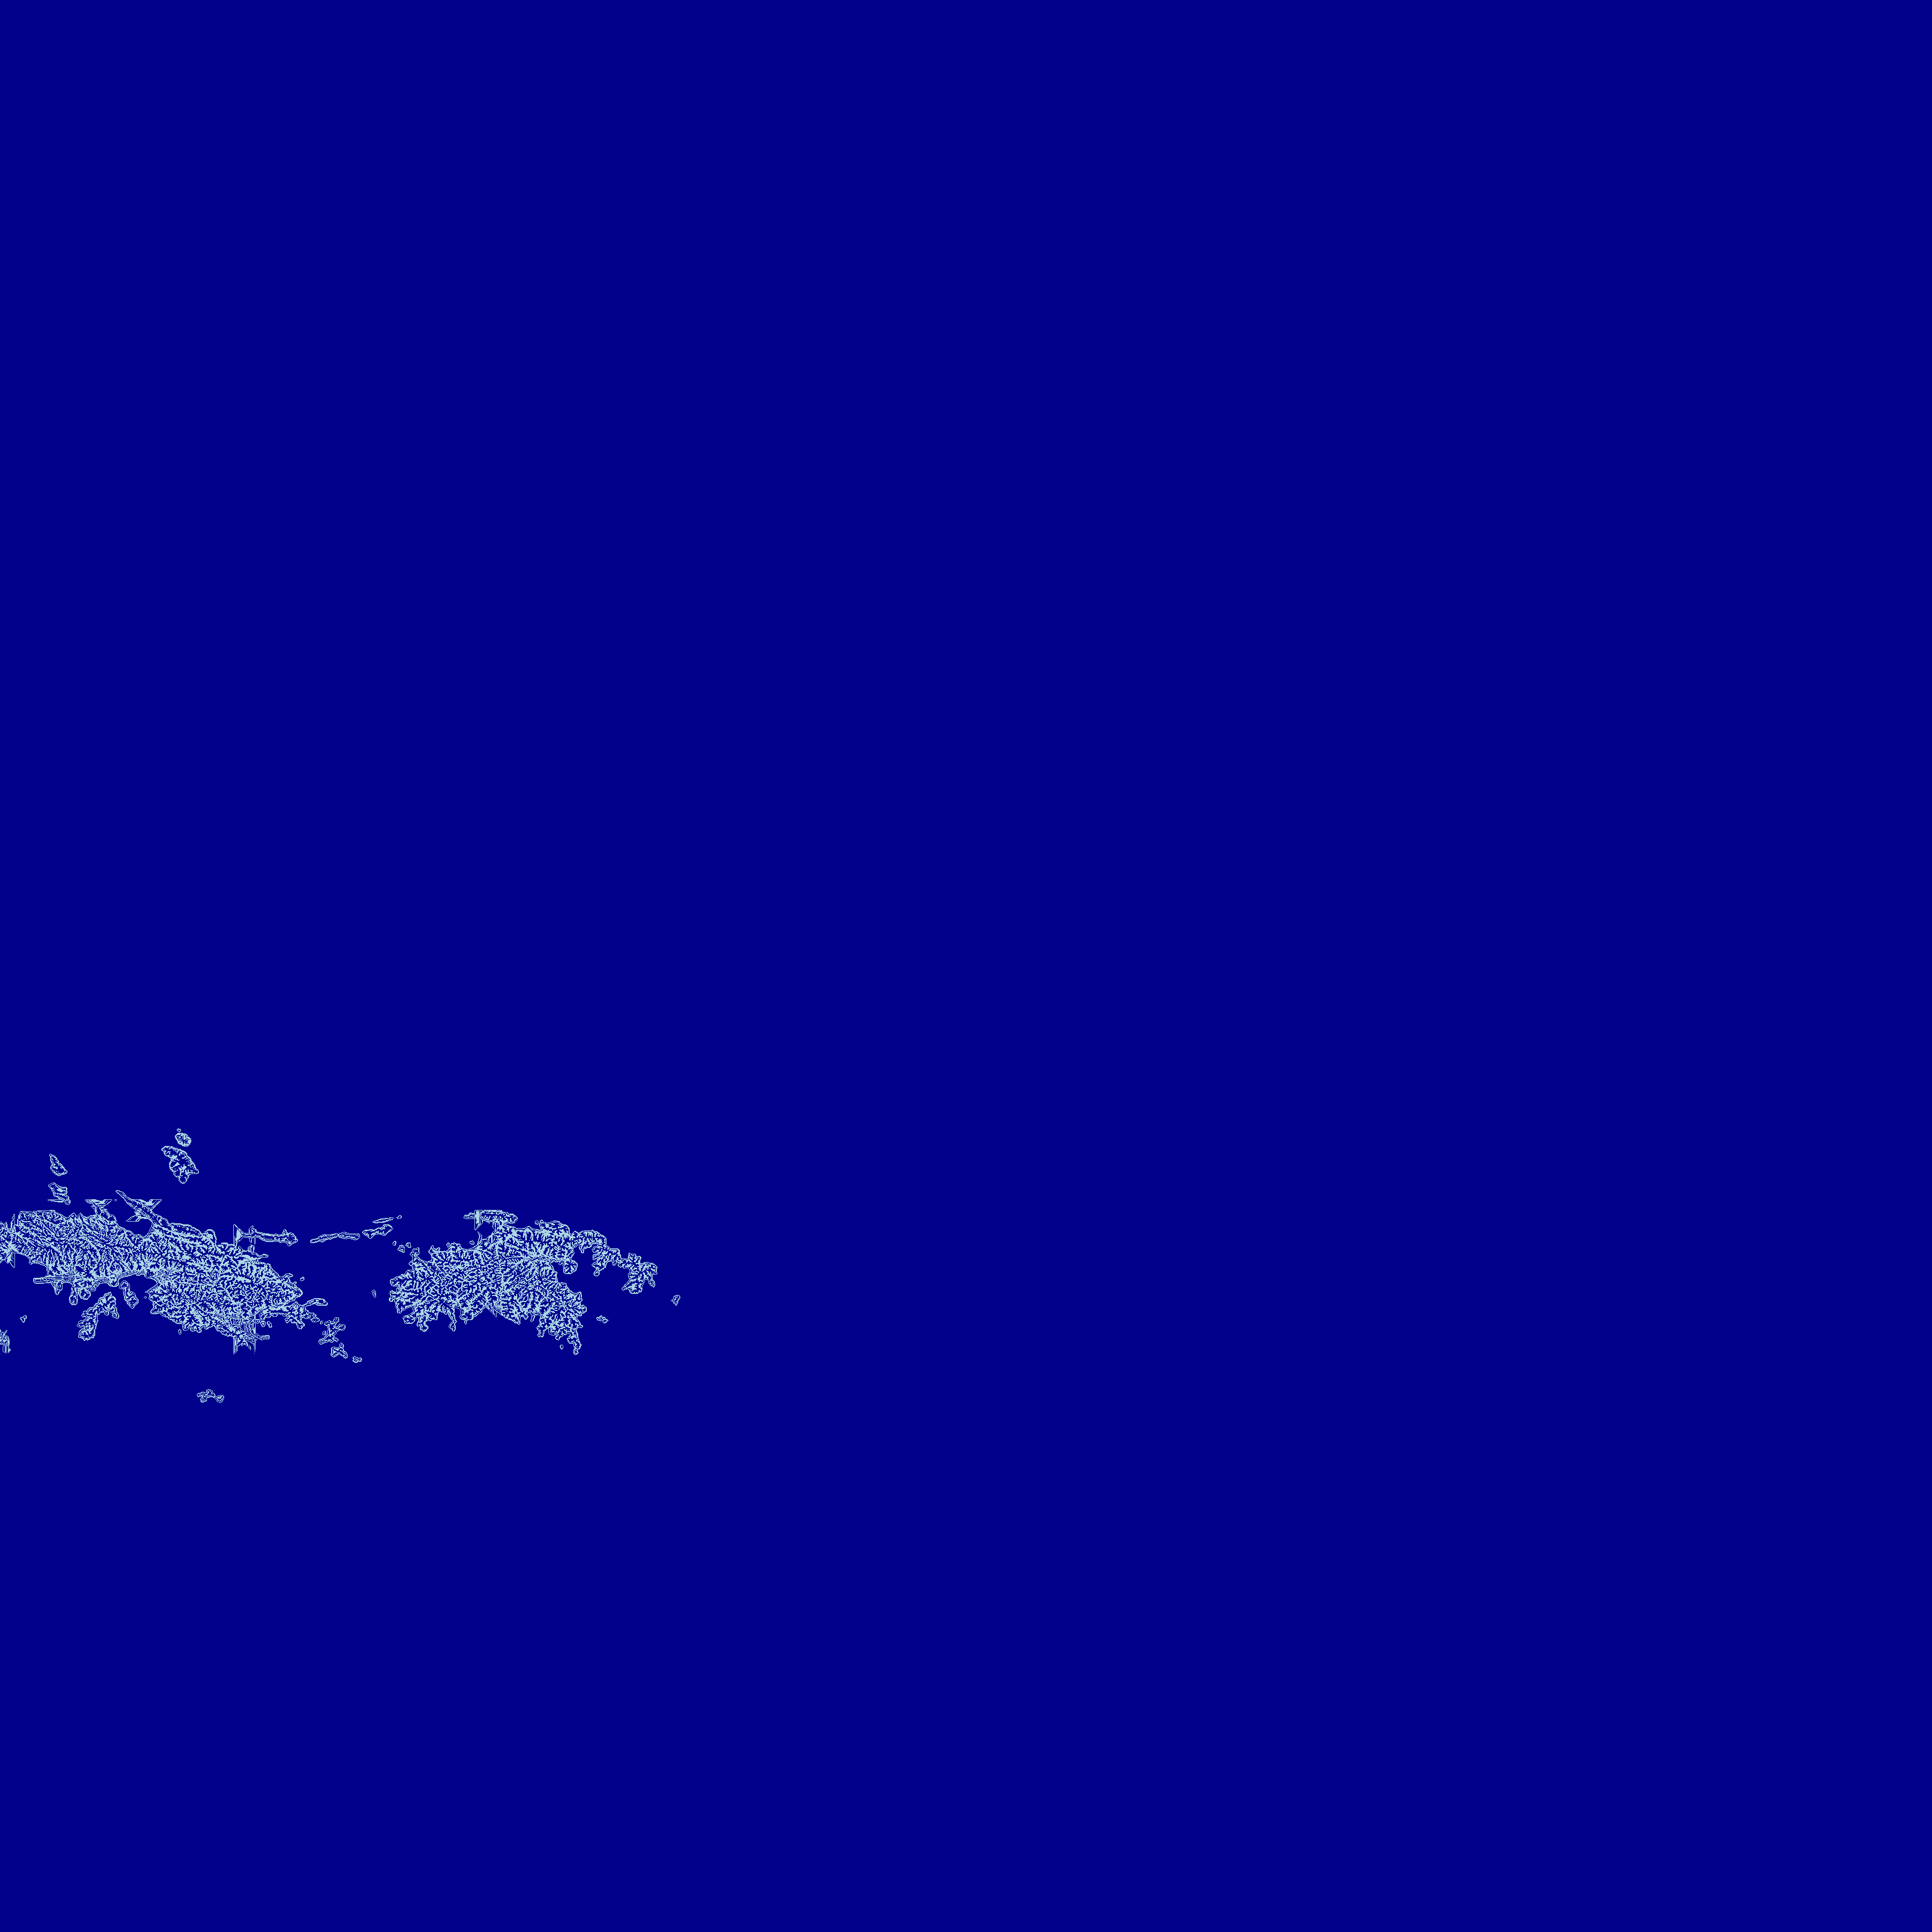

In [40]:
shade(curve)

In [9]:
#hey=xr.DataArray([1,2,3,4])

In [10]:
#hey.data

In [11]:
hillshade = xrs.hillshade(terrain)

In [12]:
#slope = xrs.slope(forxr)
#slope = slope.where(np.logical_and(slope.data > 25, slope.data < 50))
#slope = slope.where(slope.data>50)

In [13]:
#slope.hvplot.image(rasterize = True, geo = True, tiles = 'OSM', cmap = 'inferno', alpha = 20)

In [14]:
#shade(hillshaded, cmap = ['black','white'], )

In [4]:
from xrspatial import viewshed
import pandas as pd
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

from xrspatial import viewshed

terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')
W=3216
H=3216
OBSERVER_X = -12.5
OBSERVER_Y = 10

canvas = ds.Canvas(plot_width=W, plot_height=H,
                   x_range=(-20, 20), y_range=(-20, 20))

normal_df = pd.DataFrame({
   'x': np.random.normal(.5, 1, 10000000),
   'y': np.random.normal(.5, 1, 10000000)
})
normal_agg = canvas.points(normal_df, 'x', 'y')
normal_agg.values = normal_agg.values.astype("float64")
normal_shaded = shade(normal_agg)

observer_df = pd.DataFrame({'x': [OBSERVER_X], 'y': [OBSERVER_Y]})
observer_agg = canvas.points(observer_df, 'x', 'y')
observer_shaded = dynspread(shade(observer_agg, cmap=['orange']),
                            threshold=1, max_px=4)

normal_illuminated = xrs.hillshade(normal_agg)
normal_illuminated_shaded = shade(normal_illuminated, cmap=['black', 'white'], 
                                  alpha=128, how='linear')

stack(normal_illuminated_shaded, observer_shaded)

NameError: name 'terrain' is not defined

In [5]:
view = xrs.viewshed(normal_agg, x=OBSERVER_X, y=OBSERVER_Y)

view_shaded = shade(view, cmap='fuchsia', how='linear')
illuminated = xrs.hillshade(terrain)
stack(shade(illuminated, cmap=['black', 'white'], alpha=128, how='linear'),
      terrain_shaded,
      view_shaded,
      observer_shaded)

NameError: name 'normal_agg' is not defined

In [3]:
help(xrs.view())

AttributeError: module 'xrspatial' has no attribute 'view'